In [1]:
import numpy as np
import binary_dude as bd
import matplotlib.pyplot as plt
%matplotlib inline 

from numpy import *

import keras

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.optimizers import SGD, RMSprop, Adagrad, Adam, Adadelta
from keras.utils import np_utils

from architectures import *
import ndude_sim as sim

%load_ext autoreload

Using TensorFlow backend.


In [10]:
# Initialize parameters for problem
alpha=0.1
delta=0.1
nb_classes=2
L=np.array([[delta, -delta/(1-2*delta), (1-delta)/(1-2*delta)],[delta, (1-delta)/(1-2*delta), -delta/(1-2*delta)]])
L_new=-L+(1-delta)/(1-2*delta)     # A new loss matrix
k_max=100

print(L_new)

# -----------------------------------------------------
# For directly loading an image data 
# and generating noisy version of it
# -----------------------------------------------------
from PIL import Image
im=Image.open('Einstein256_256.jpg').convert('L')

# Reshape image into vector
imarray=np.array(im)
n=imarray.shape[0]*imarray.shape[1]

# Convert image to binary, then pass through BSC
im_bin=bd.make_binary_image(imarray)
x=im_bin.copy().reshape(n,)
z=bd.bsc(x,delta)
# -----------------------------------------------------
# Save the clean and noisy data
# -----------------------------------------------------

np.savez('Einstein_NIPS_camera_data',x=x,z=z)
# -----------------------------------------------------
# For loading pre-generated data
# -----------------------------------------------------
# npzfile = np.load('Einstein_NIPS_camera_data.npz')
# x=npzfile['x']
# z=npzfile['z']
# -----------------------------------------------------

n=x.shape[0]

[[ 1.025  1.25   0.   ]
 [ 1.025  0.     1.25 ]]


In [11]:
Z=np_utils.to_categorical(z,nb_classes)    # Convert the z n-vector in a 2xn matrix whose columns are one-hot vectors for z values
err_nn_k=zeros(k_max)    # Initialize DUDE and Neural DUDE error calculation vectors
err_dude_k=zeros(k_max)

err_dude_k[0]=delta    # Assume just repeating input when context size is 0
err_nn_k[0]=delta

est_loss=zeros((1,k_max))
est_loss[0]=0.1

x_hat_dude=np.zeros((k_max,n))
x_hat_n_dude=np.zeros((k_max,n))

k_range=range(1,k_max)
print(k_range)

In [14]:
# -----------------------------------------------------
# For directly generating data for Neural DUDE
# -----------------------------------------------------
batch_size=50
# -----------------------------------------------------

# Form model from variable-k RNN with separate left (causal) and right (anti-causal) context inputs
model = RNNCandACVariable(nb_classes,k_max)
# Compile model for training with poisson loss and Adam optimization
model.compile(loss='poisson', optimizer=Adam())

# Build arrray holding all possible contexts of all variable context sizes
ls = []    # Array indexed by context size, whose elements are the left contexts at every point for that context size
rs = []    # Array indexed by context size, whose elements are the right contexts at every point for that context size
Ys = []    # Array indexed by context size, whose elements are the loss vectors
for k in k_range:
    l=np.zeros((n-2*k, k_max))
    r=np.zeros((n-2*k, k_max))

    for i in range(k,n-k):
        difference = k_max - k
        l[i-k,difference:]=z[i-k:i]+1
        r[i-k,difference:]=z[i+k:i:-1]+1
    ls.append(l)
    rs.append(r)
    Y=np.dot(Z[k:n-k,],L_new)    
    Ys.append(Y)
        

def batch_generate(ks, batch_size, ls, rs, Ys):
    """Generate the batch data for training the variable-k modified RNN
    
    Arguments: 
    ks -- range of k values to consider
    batch_size -- number of samples to take for one training batch
    ls -- array holding all possible left contexts of all variable context sizes
    rs -- array holding all possible right contexts of all variable context sizes
    Ys -- array holding all loss vector for all variable context sizes
    
    Output:
    g -- generator for training data
    """
    while True:
        kindex = np.random.randint(len(ks))
        k = ks[kindex]
        batch_indices = np.random.randint(n-2*k,size=batch_size)
        #print(batch_indices-k)
        l = ls[kindex]
        r = rs[kindex]
        c = [l[batch_indices,],r[batch_indices,]]
        Y = Ys[kindex]
        y = Y[batch_indices,:]
        yield c, y
        

# Get a generator for the training data
g = batch_generate(k_range, batch_size, ls, rs, Ys)
print('Model fitting...')
# Fit the model based on the data generator g
history = model.fit_generator(g, 100, nb_epoch=5, verbose=1)

# -----------------------------------------------------

# We evaluate RNN Neural DUDE performance for each value of context size k
for i in range(len(k_range)):
    k = k_range[i]
    
    pred_class=model.predict([ls[i],rs[i]], batch_size=200, verbose=0).argmax(axis=1) # Run prediction
    
    print('k=',k)
    s_nn_hat=hstack((zeros(k),pred_class,zeros(k))) # Generate estimator sequence and denoise data
    x_nn_hat=bd.denoise_with_s(z,s_nn_hat,k)
    error_nn=bd.error_rate(x,x_nn_hat) # Calculate average hamming loss for RNN Neural DUDE
    print('error_nn=', error_nn)
    err_nn_k[k]=error_nn # Store results in history vector
    x_hat_n_dude[k,:]=x_nn_hat

    # Calculate estimated loss measures
    s_class=3
    s_nn_hat_cat=np_utils.to_categorical(s_nn_hat,s_class) # Convert estimator sequences into one-hot vectors for calculations
    emp_dist=dot(Z,L)
    est_loss_nn_dude=mean(sum(emp_dist*s_nn_hat_cat,axis=1)) # Dot loss estimator with signal estimator for estimated loss
    est_loss[k]=est_loss_nn_dude # Store results in history vector

Model fitting...
Epoch 1/5
100/100 [==============================] - 4s - loss: 1.1075     
Epoch 2/5
100/100 [==============================] - 4s - loss: 1.0697     
Epoch 3/5
100/100 [==============================] - 4s - loss: 1.0515     
Epoch 4/5
100/100 [==============================] - 4s - loss: 1.0457     
Epoch 5/5
100/100 [==============================] - 4s - loss: 1.0436     
k= 1
error_nn= 0.100448608398
error_dude= 0.100448608398
k= 2
error_nn= 0.110626220703
error_dude= 0.0936279296875
k= 3
error_nn= 0.0993347167969
error_dude= 0.0919342041016
k= 4
error_nn= 0.105606079102
error_dude= 0.0924072265625
k= 5
error_nn= 0.0760650634766
error_dude= 0.0550231933594
k= 6
error_nn= 0.0747528076172
error_dude= 0.0585174560547
k= 7
error_nn= 0.0672454833984
error_dude= 0.0635375976562
k= 8
error_nn= 0.0634002685547
error_dude= 0.0694732666016
k= 9
error_nn= 0.0629425048828
error_dude= 0.0762176513672
k= 10
error_nn= 0.0542297363281
error_dude= 0.0770568847656
k= 11
error_nn= 

/home/cs231n/myVE35/lib/python3.5/site-packages/ipykernel/__main__.py:46: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., 100, epochs=5, verbose=1)`


In [10]:
# Get data for the Neural DUDE and DUDE
source = "Einstein256_256"
k_dnn, est_loss_dnn, err_dude_k, err_nn_k_dnn, x_dude_hat, x_nn_hat_dnn, x_dnn, z_dnn = sim.simulate_ndude(source=source, k_max=39, delta=delta, relmodel=False, architecture="dnn")

Lnew: [[ 1.025  1.25   0.   ]
 [ 1.025  0.     1.25 ]]
k range:  range(1, 40)
k= 1
Model fitting...
Saving model...
error_nn= 0.100784301758
error_dude= 0.100784301758
k= 2
Model fitting...
Saving model...
error_nn= 0.0941925048828
error_dude= 0.0941925048828
k= 3
Model fitting...
Saving model...
error_nn= 0.0921325683594
error_dude= 0.092041015625
k= 4
Model fitting...
Saving model...
error_nn= 0.0927429199219
error_dude= 0.0917816162109
k= 5
Model fitting...
Saving model...
error_nn= 0.0558013916016
error_dude= 0.0547790527344
k= 6
Model fitting...
Saving model...
error_nn= 0.0598449707031
error_dude= 0.0584106445312
k= 7
Model fitting...
Saving model...
error_nn= 0.0724639892578
error_dude= 0.0630950927734
k= 8
Model fitting...
Saving model...
error_nn= 0.062255859375
error_dude= 0.0708618164062
k= 9
Model fitting...
Saving model...
error_nn= 0.0631561279297
error_dude= 0.0767822265625
k= 10
Model fitting...
Saving model...
error_nn= 0.0492248535156
error_dude= 0.0784149169922
k= 11

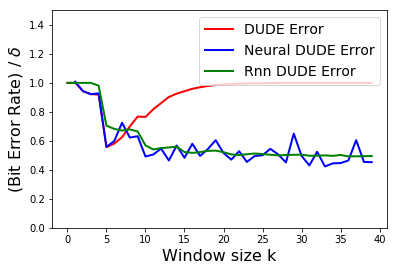

In [18]:
# Plot the 
k=range(k_max)
plt.plot(k,err_dude_k/delta,'r',linewidth=2.0) # Plot DUDE loss
# plt.plot(k,est_loss_dnn[0,:]/delta,'r-*',linewidth=2.0) # Plot DUDE estimated loss
plt.plot(k[1:],err_nn_k_dnn/delta,'b',linewidth=2.0) # Plot Neural DUDE loss
# plt.plot(k[1:],est_loss_dnn[1,:]/delta,'b-*',linewidth=2.0) # Plot Neural DUDE estimated loss
plt.plot(k,err_nn_k/delta,'g',linewidth=2.0) # Plot RNN Neural DUDE loss
# plt.plot(k,est_loss/delta,'g-*',linewidth=2.0) # Plot RNN Neural DUDE estimated loss
# plt.plot(k,0.558*np.ones(15),'k',linewidth=2.0) # Plot FB Recursion loss
plt.ylim((0,1.5))
plt.xlabel('Window size k',fontsize=16)
plt.ylabel('(Bit Error Rate) / $\delta$',fontsize=16)
plt.legend(['DUDE Error', 'Neural DUDE Error', 'Rnn DUDE Error'],loc='upper right',fontsize=14)

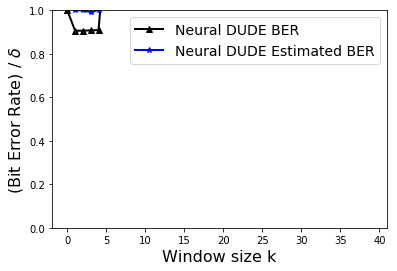

In [9]:
# Compare RNN Neural DUDE BER vs. Estimated BER
k=range(k_max)
plt.plot(k,err_nn_k/delta,'k-^',linewidth=2.0) # Plot RNN Neural DUDE loss
plt.plot(k,est_loss/delta,'b-*',linewidth=2.0) # Plot RNN Neural DUDE estimated loss
# plt.plot(k,0.558*np.ones(15),'k',linewidth=2.0) # Plot FB Recursion loss
plt.ylim((0,1.5))
plt.xlabel('Window size k',fontsize=16)
plt.ylabel('(Bit Error Rate) / $\delta$',fontsize=16)
plt.legend(['Neural DUDE BER','Neural DUDE Estimated BER'],loc='upper right',fontsize=14)

In [ ]:
# Import matplotlib for activating tex rendering (publish-ready image quality)
import matplotlib
matplotlib.rcParams['text.usetex'] = True

In [ ]:
# Compare RNN Neural DUDE to DUDE
k=range(k_max)
plt.plot(k,err_dude_k/delta,'r',linewidth=2.0) # Plot DUDE loss
plt.plot(k,err_nn_k/delta,'b-^',linewidth=2.0) # Plot RNN Neural DUDE loss
plt.plot(k,est_loss/delta,'b-*',linewidth=2.0) # Plot RNN Neural DUDE estimated loss

plt.legend(['DUDE BER','RNN Neural DUDE BER','RNN Neural DUDE Est. BER'],fontsize=14)
plt.ylim((0.3,1.5))
plt.xlabel('Window size k',fontsize=16)
plt.ylabel('(Bit Error Rate) / $\delta$',fontsize=16)

In [ ]:
# Compare estimated losses for DUDE and RNN Neural DUDE
k=range(k_max)
plt.plot(k,est_loss_dnn[0,]*10,'r',linewidth=2.0) # Plot DUDE estimated loss
plt.plot(k,est_loss*10,'b-^',linewidth=2.0) # Plot RNN Neural DUDE estimated loss
plt.legend(['Baseline','Proposed (RNN)'],fontsize=14)

plt.ylim((-1.25,1.5))
plt.xlabel('Context size k',fontsize=16)
plt.ylabel('(Bit Error Rate) / $\delta$',fontsize=16)

In [ ]:
plt.imshow(x_dude_hat.reshape((256,256)),cmap=plt.cm.gray) # Show the DUDE reconstruction of the image

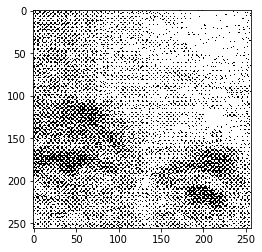

In [9]:
plt.imshow(x_nn_hat.reshape((256,256)),cmap=plt.cm.gray) # Show the RNN Neural DUDE reconstruction of the image

In [ ]:
plt.imshow(z.reshape((256,256)),cmap=plt.cm.gray) # Show the noisy image

In [ ]:
plt.imshow(x.reshape((256,256)),cmap=plt.cm.gray) # Show the clean image